# Block 1: Databeredning 

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

# Sökvägar
HAM_DIR = '/kaggle/input/skin-cancer-mnist-ham10000/'
ISIC_DIR = '/kaggle/input/isic-2019-skin-lesion-images-for-classification/'

def display_compact_stats(df, name):

    # 1. Kön
    sex = df['sex'].value_counts().reset_index()
    sex.columns = ['Detalj', 'Värde']
    sex['Kategori'] = 'KÖN'

    # 2. Lokalisering
    loc_col = 'localization' if 'localization' in df.columns else 'anatom_site_general'
    loc = df[loc_col].value_counts().reset_index()
    loc.columns = ['Detalj', 'Värde']
    loc['Kategori'] = 'PLATS PÅ KROPPEN'

    # 3. Ålder
    age_raw = df['age_approx'].describe()
    age_data = [
        ['Medelålder', age_raw['mean'], 'ÅLDER'],
        ['Median', age_raw['50%'], 'ÅLDER'],
        ['Yngsta', age_raw['min'], 'ÅLDER'],
        ['Äldsta', age_raw['max'], 'ÅLDER']
    ]
    age = pd.DataFrame(age_data, columns=['Detalj', 'Värde', 'Kategori'])

    combined_meta = pd.concat([sex, loc, age], axis=0)
    combined_meta = combined_meta.set_index(['Kategori', 'Detalj'])

    print(f"\n--- Metadata översikt: {name} ---")
    
    styled_df = combined_meta.style.background_gradient(cmap='Blues', subset=['Värde'], axis=0)\
                .format(precision=2)
    
    display(styled_df)

def analyze_dataset(df, name):

    malignant_types = ['mel', 'bcc', 'scc']
    precancer_types = ['ak', 'akiec']
    
    def get_status(dx):
        if dx in malignant_types: return 'Malignant (Cancer)'
        if dx in precancer_types: return 'Pre-cancer/Risk'
        return 'Benign (Frisk)'

    diag_names = {
        'nv': 'Melanocytic Nevi', 'mel': 'Melanoma', 'bkl': 'Benign Keratosis',
        'bcc': 'Basal Cell Carcinoma', 'scc': 'Squamous Cell Carcinoma',
        'ak': 'Actinic Keratosis', 'akiec': 'Bowens Disease',
        'vasc': 'Vascular Lesion', 'df': 'Dermatofibroma', 'unknown': 'Unknown'
    }

    # Diagnos-tabell
    stats = df.groupby('dx').size().reset_index(name='Antal Bilder')
    stats['Diagnos (Fullständigt namn)'] = stats['dx'].map(diag_names)
    stats['Klinisk Status'] = stats['dx'].apply(get_status)
    stats = stats.sort_values(by=['Klinisk Status', 'Antal Bilder'], ascending=[False, False])
    
    print(f"\n" + "="*60)
    print(f"Diagnos statistik: {name}")
    print("="*60)
    display(stats[['Diagnos (Fullständigt namn)', 'Klinisk Status', 'Antal Bilder', 'dx']].set_index('Diagnos (Fullständigt namn)'))
    
    # Metadata
    display_compact_stats(df, name)
    print(f"Totalt antal bilder i {name}: {len(df)}\n")

def build_master_df():
    # 1. HAM10000
    ham_df = pd.read_csv(os.path.join(HAM_DIR, 'HAM10000_metadata.csv'))
    ham_img_paths = glob.glob(os.path.join(HAM_DIR, "HAM10000_images_part_*/*.jpg"))
    ham_path_map = {os.path.splitext(os.path.basename(x))[0]: x for x in ham_img_paths}
    ham_df['path'] = ham_df['image_id'].map(ham_path_map)
    ham_df = ham_df.rename(columns={'age': 'age_approx'})
    analyze_dataset(ham_df, "HAM10000")

    # 2. ISIC 2019
    isic_metadata = pd.read_csv(os.path.join(ISIC_DIR, 'ISIC_2019_Training_Metadata.csv'))
    isic_labels = pd.read_csv(os.path.join(ISIC_DIR, 'ISIC_2019_Training_GroundTruth.csv'))
    isic_df = pd.merge(isic_metadata, isic_labels, on='image')
    isic_img_paths = glob.glob(os.path.join(ISIC_DIR, "*/*.jpg")) 
    isic_path_map = {os.path.splitext(os.path.basename(x))[0]: x for x in isic_img_paths}
    isic_df['path'] = isic_df['image'].map(isic_path_map)

    if 'anatom_site_general' in isic_df.columns:
        isic_df = isic_df.rename(columns={'anatom_site_general': 'localization'})

    def map_isic(row):
        cols = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC']
        for col in cols:
            if col in row and row[col] == 1.0: return col.lower()
        return 'unknown'
    
    isic_df['dx'] = isic_df.apply(map_isic, axis=1)
    analyze_dataset(isic_df, "ISIC 2019")

    # 3. Slå ihop och städa
    common_cols = ['path', 'dx', 'age_approx', 'sex', 'localization']
    for df_temp in [ham_df, isic_df]:
        for col in common_cols:
            if col not in df_temp.columns: df_temp[col] = "unknown"

    combined_df = pd.concat([ham_df[common_cols], isic_df[common_cols]], axis=0)
    combined_df['age_approx'] = pd.to_numeric(combined_df['age_approx'], errors='coerce').fillna(combined_df['age_approx'].mean())
    combined_df['sex'] = combined_df['sex'].fillna('unknown')
    combined_df['localization'] = combined_df['localization'].fillna('unknown')
    
    # One-Hot Encoding
    combined_df = pd.get_dummies(combined_df, columns=['sex', 'localization'])
    label_map = {'ak': 0, 'akiec': 0, 'scc': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
    combined_df['label'] = combined_df['dx'].map(label_map)
    combined_df = combined_df.dropna(subset=['label', 'path'])
    
    return combined_df.reset_index(drop=True)

# Exekvera
df = build_master_df()
meta_cols = [c for c in df.columns if 'sex_' in c or 'localization_' in c] + ['age_approx']

print("\n" + "="*60)
print(f"Slutligt resultat")
print(f"Sammanlagt total antal bilder: {len(df)} bilder")
print(f"Antal metadata-attribut (One-hot): {len(meta_cols)}")
print("="*60)


Diagnos statistik: HAM10000


,Klinisk Status,Antal Bilder,dx
Diagnos (Fullständigt namn),,,
Bowens Disease,Pre-cancer/Risk,327,akiec
Melanoma,Malignant (Cancer),1113,mel
Basal Cell Carcinoma,Malignant (Cancer),514,bcc
Melanocytic Nevi,Benign (Frisk),6705,nv
Benign Keratosis,Benign (Frisk),1099,bkl
Vascular Lesion,Benign (Frisk),142,vasc
Dermatofibroma,Benign (Frisk),115,df



--- Metadata översikt: HAM10000 ---


Totalt antal bilder i HAM10000: 10015


Diagnos statistik: ISIC 2019


,Klinisk Status,Antal Bilder,dx
Diagnos (Fullständigt namn),,,
Actinic Keratosis,Pre-cancer/Risk,867,ak
Melanoma,Malignant (Cancer),4522,mel
Basal Cell Carcinoma,Malignant (Cancer),3323,bcc
Squamous Cell Carcinoma,Malignant (Cancer),628,scc
Melanocytic Nevi,Benign (Frisk),12875,nv
Benign Keratosis,Benign (Frisk),2624,bkl
Vascular Lesion,Benign (Frisk),253,vasc
Dermatofibroma,Benign (Frisk),239,df



--- Metadata översikt: ISIC 2019 ---


Totalt antal bilder i ISIC 2019: 25331


Suligt resultat
Sammanlagt total antal bilder: 35346 bilder
Antal metadata-attribut (One-hot): 25


___
# Block 2: Databehandling


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2

# DullRazor och process_img
def dull_razor(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)
    return dst
    
# Augmenteringsfunktion
def process_img(path, is_training):
    path_str = path.numpy().decode()
    img = cv2.imread(path_str)
    if img is None: return np.zeros((224,224,3), dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = dull_razor(img)
    img = cv2.resize(img, (224, 224))
    if is_training:
        if np.random.rand() > 0.5: img = cv2.flip(img, 1)
        if np.random.rand() > 0.5: img = cv2.flip(img, 0)
        if np.random.rand() > 0.5:
            angle = np.random.uniform(-20, 20)
            M = cv2.getRotationMatrix2D((112,112), angle, 1.0)
            img = cv2.warpAffine(img, M, (224,224))
    return img.astype(np.float32) / 255.0

# Balansering av dataframe 
def balance_dataframe(df):
    df_balanced = pd.DataFrame()
    target_count_nv = 6000 
    
    for label in range(7):
        class_subset = df[df['label'] == label]
        
        if label == 5:
            class_subset = class_subset.sample(n=min(len(class_subset), target_count_nv), random_state=42)
        
        df_balanced = pd.concat([df_balanced, class_subset], axis=0)
    
    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Applicera balanseringen på grund-df
df_balanced = balance_dataframe(df)

# Pipeline och split
def make_balanced_dataset(subset_df, is_training=True):
    def map_fn(p, m, l):
        [img] = tf.py_function(process_img, [p, is_training], [tf.float32])
        img.set_shape((224, 224, 3))
        return {"image_input": img, "meta_input": m}, l
    
    class_datasets = []
    for label in range(7):
        class_df = subset_df[subset_df['label'] == label]
        if len(class_df) == 0: continue
        
        paths = class_df['path'].values
        metas = class_df[meta_cols].values.astype(np.float32)
        labels = class_df['label'].values.astype(np.int32)
        
        ds = tf.data.Dataset.from_tensor_slices((paths, metas, labels))
        if is_training:
            ds = ds.shuffle(len(class_df)).repeat()
        class_datasets.append(ds)
    
    if is_training:
        combined_ds = tf.data.Dataset.sample_from_datasets(class_datasets, weights=[1/len(class_datasets)]*len(class_datasets))
    else:
        combined_ds = tf.data.Dataset.from_tensor_slices(
            (subset_df['path'].values, subset_df[meta_cols].values.astype(np.float32), subset_df['label'].values.astype(np.int32))
        )
        
    return combined_ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# Splitta den balanserade datan
temp_df, test_df = train_test_split(df_balanced, test_size=0.05, stratify=df_balanced['label'], random_state=42)
train_df, val_df = train_test_split(temp_df, test_size=0.15, stratify=temp_df['label'], random_state=42)

train_ds = make_balanced_dataset(train_df, is_training=True)
val_ds = make_balanced_dataset(val_df, is_training=False)
test_ds = make_balanced_dataset(test_df, is_training=False)

# 1. Tabell per diagnos
label_map = {
    0: ('AKIEC', 'Sjuk (Förstadium)'),
    1: ('BCC', 'Sjuk (Cancer)'),
    2: ('BKL', 'Frisk/Godartad'),
    3: ('DF', 'Frisk/Godartad'),
    4: ('MEL', 'Sjuk (Farlig Cancer)'),
    5: ('NV', 'Frisk (Födelsemärke)'),
    6: ('VASC', 'Frisk/Godartad')
}

label_counts = df_balanced['label'].value_counts().sort_index()
stats_data = []
sjuk_count = 0
frisk_count = 0

for label, count in label_counts.items():
    code, status = label_map[label]
    stats_data.append([code, status, count])
    
    if "Sjuk" in status:
        sjuk_count += count
    else:
        frisk_count += count

stats_df = pd.DataFrame(stats_data, columns=['Diagnos', 'Klinisk Status', 'Antal Bilder'])

print(f"\n" + "="*60)
print(f"TRÄNINGSDATA: DIAGNOS-FÖRDELNING")
print("="*60)
display(stats_df.set_index('Diagnos'))

# 2. Sammanfattande tabell (Frisk vs Sjuk)
summary_data = {
    'Kategori': ['Totalt Sjuk (Cancer/Risk)', 'Totalt Frisk (Benign)'],
    'Antal Bilder': [sjuk_count, frisk_count],
    'Andel (%)': [f"{(sjuk_count/len(df_balanced)*100):.1f}%", f"{(frisk_count/len(df_balanced)*100):.1f}%"]
}
summary_df = pd.DataFrame(summary_data)

print(f"\n" + "="*60)
print(f"TRÄNINGSDATA: TOTAL BALANS")
print("="*60)
display(summary_df.set_index('Kategori'))

# 3. Kompakt Metadata-tabell för Träningssetet
def display_balanced_metadata(df):
    # Kön-statistik (från one-hot)
    sex_cols = [c for c in df.columns if 'sex_' in c]
    sex_counts = df[sex_cols].sum().reset_index()
    sex_counts.columns = ['Detalj', 'Värde']
    sex_counts['Detalj'] = sex_counts['Detalj'].str.replace('sex_', '').str.capitalize()
    sex_counts['Kategori'] = 'KÖN'

    # Plats-statistik (från one-hot)
    loc_cols = [c for c in df.columns if 'localization_' in c]
    loc_counts = df[loc_cols].sum().reset_index()
    loc_counts.columns = ['Detalj', 'Värde']
    loc_counts['Detalj'] = loc_counts['Detalj'].str.replace('localization_', '').str.replace('_', ' ').str.capitalize()
    loc_counts['Kategori'] = 'PLATS PÅ KROPPEN'

    # Ålder-statistik
    age_raw = df['age_approx'].describe()
    age_data = [
        ['Medelålder', age_raw['mean'], 'ÅLDER'],
        ['Median', age_raw['50%'], 'ÅLDER'],
        ['Yngsta', age_raw['min'], 'ÅLDER'],
        ['Äldsta', age_raw['max'], 'ÅLDER']
    ]
    age = pd.DataFrame(age_data, columns=['Detalj', 'Värde', 'Kategori'])

    combined_meta = pd.concat([sex_counts, loc_counts, age], axis=0)
    combined_meta = combined_meta.set_index(['Kategori', 'Detalj'])

    print(f"\n" + "="*60)
    print(f"TRÄNINGSDATA: METADATA-FÖRDELNING (EFTER BALANSERING)")
    print("="*60)
    display(combined_meta.style.background_gradient(cmap='Greens', subset=['Värde'], axis=0).format(precision=2))

display_balanced_metadata(df_balanced)
print(f"Totalt antal bilder i balanserad dataset: {len(df_balanced)}")


TRÄNINGSDATA: DIAGNOS-FÖRDELNING


,Klinisk Status,Antal Bilder
Diagnos,,
AKIEC,Sjuk (Förstadium),1822
BCC,Sjuk (Cancer),3837
BKL,Frisk/Godartad,3723
DF,Frisk/Godartad,354
MEL,Sjuk (Farlig Cancer),5635
NV,Frisk (Födelsemärke),6000
VASC,Frisk/Godartad,395



TRÄNINGSDATA: TOTAL BALANS


,Antal Bilder,Andel (%)
Kategori,,
Totalt Sjuk (Cancer/Risk),11294,51.9%
Totalt Frisk (Benign),10472,48.1%



TRÄNINGSDATA: METADATA-FÖRDELNING (EFTER BALANSERING)


Totalt antal bilder i balanserad dataset: 21766


___
# Block 3: Ensemble Arkitektur

In [6]:
# 1. Definiera Triple Ensemble-modellen
def build_triple_ensemble(num_classes, meta_dim):
    img_input = tf.keras.layers.Input(shape=(224, 224, 3), name="image_input")
    meta_input = tf.keras.layers.Input(shape=(meta_dim,), name="meta_input")

    # 1. ResNet50V2 (Stabilitet - bra grund)
    res = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', pooling='avg')(img_input)
    
    # 2. ConvNeXtTiny (Texturer - bra på att se små färgskiftningar)
    convnext = tf.keras.applications.ConvNeXtTiny(include_top=False, weights='imagenet', pooling='avg')(img_input)
    
    # 3. EfficientNetV2S (Global struktur - ser helheten)
    eff = tf.keras.applications.EfficientNetV2S(include_top=False, weights='imagenet', pooling='avg')(img_input)

    # 4. Metadata-gren (Patientinfo)
    m = tf.keras.layers.Dense(64, activation='relu')(meta_input)
    m = tf.keras.layers.BatchNormalization()(m)

    # FUSION: Slå ihop allt
    combined = tf.keras.layers.concatenate([res, convnext, eff, m])

    # Slutlager
    x = tf.keras.layers.Dense(512, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, meta_input], outputs=output)

# 2. Skapa modellen
try:
    meta_dim_size = len(meta_cols)
except NameError:
    meta_dim_size = 25 
    print("Varning: 'meta_cols' saknas, använder standardvärde 25.")

model = build_triple_ensemble(num_classes=7, meta_dim=meta_dim_size)

# Skapa data för tabellen med exakta värden från specifikation
split_data = [
    ["Träningsdata (Train)", 17575, "80.7%", "Modellen lär sig parametrar"],
    ["Valideringsdata (Val)", 3102, "14.3%", "Styr EarlyStopping & LR"],
    ["Testdata (Test)", 1089, "5.0%", "Slutlig oberoende kontroll"],
    ["TOTALT", 21766, "100%", "Balanserat dataset"]
]

split_df = pd.DataFrame(split_data, columns=["Dataset", "Antal Bilder", "Andel (%)", "Syfte"])

# Utskrift av info och tabell
print("="*65)
print("MODELL & DATAFÖRDELNING")
print("="*65)
print(f"Modell: Triple Ensemble (ResNet50 + ConvNeXt + EfficientNet)")
print(f"Input:  Bild (224x224) + Metadata ({meta_dim_size} st)")
print("-" * 65)
from IPython.display import display
display(split_df)
print("="*65)

# Hämtning av parametrar
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print("\nParameter-optimering:")
print(f"Totalt antal parametrar: {total_params:,}".replace(",", " "))
print(f"Tränbara parametrar:   {trainable_params:,} (Endast de sista lagren)".replace(",", " "))
print(f"Icke-tränbara parametrar:: {non_trainable_params:,} (Grundkunskap bevarad)")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
MODELL & DATAFÖRDELNING
Modell: Triple Ensemble (ResNet50 + ConvNeXt + EfficientNet)
Input:  Bild (224x224) + Metadata (25 st)
-----------------------------------------------------------------


,Dataset,Antal Bilder,Andel (%),Syfte
0,Träningsdata (Train),17575,80.7%,Modellen lär sig parametrar
1,Valideringsdata (Val),3102,14.3%,Styr EarlyStopping & LR
2,Testdata (Test),1089,5.0%,Slutlig oberoende kontroll
3,TOTALT,21766,100%,Balanserat dataset



Parameter-optimering:
Totalt antal parametrar: 73 852 231
Parametrar som tränas:   73 652 791 (Endast de sista lagren)
Parametrar som är frysta: 199,440 (Grundkunskap bevarad)


___
# Block 4: Träningslogik

In [8]:
from IPython.display import FileLink

# 1. Definera Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=7)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        fl = -y_true * alpha * tf.pow(1.0 - y_pred, gamma) * tf.math.log(y_pred)
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return loss_fn

# 2. Optimerare och inlärningshastighet
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
    loss=focal_loss(),
    metrics=['accuracy'] 
)

# 3. Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='dermascan_best_model.keras', 
        save_best_only=True, 
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    # Sänker LR om modellen fastnar på samma nivå
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3,
        verbose=1
    ),
    # EarlyStopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=7, 
        restore_best_weights=True,
        verbose=1
    )
]

# 4. Träning
print(f"Startar träning på {len(train_df)} bilder...")

history = model.fit(
    train_ds,
    steps_per_epoch=len(train_df) // 32,
    validation_data=val_ds,
    validation_steps=len(val_df) // 32,
    epochs=18, 
    callbacks=callbacks,
    verbose=1
)

# 5. Resultat
print("\n" + "="*60)
print("TRÄNING KLAR!")
print(f"Bästa validerings-noggrannhet: {max(history.history['val_accuracy'])*100:.2f}%")
print("="*60)

try:
    print("\nKlicka på länken nedan för att ladda ner din färdigtränade modell:")
    display(FileLink(r'dermascan_best_model.keras'))
except:
    print("\nModellen sparad som 'dermascan_best_model.keras' i Kaggle Output-mappen.")

Startar träning på 17575 bilder...
Epoch 1/18
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4508 - loss: 0.2445
Epoch 1: val_accuracy improved from -inf to 0.65918, saving model to dermascan_best_model.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 1002s 1s/step - accuracy: 0.4510 - loss: 0.2444 - val_accuracy: 0.6592 - val_loss: 0.1332 - learning_rate: 5.0000e-05
Epoch 2/18
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7160 - loss: 0.1021
Epoch 2: val_accuracy improved from 0.65918 to 0.70671, saving model to dermascan_best_model.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.7160 - loss: 0.1021 - val_accuracy: 0.7067 - val_loss: 0.1000 - learning_rate: 5.0000e-05
Epoch 3/18
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7641 - loss: 0.0766
Epoch 3: val_accuracy improved from 0.70671 to 0.72428, saving model to dermascan_best_model.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 689s 1s/step - accuracy: 0.7642 - loss: 0.0766 - val_accuracy: 0.7243 - val_loss: 0.0907 - lea

/kaggle/working/dermascan_best_model.keras

___
# Block 5: Utvärdering och Resultatrapport

 Genererar diagnoser för VALIDERINGSDATA...

KLINISK RAPPORT: VALIDERINGSDATA


,Precision (%),Recall (%),F1-Score (%),Antal Bilder (st)
AKIEC,82.18,86.92,84.49,260
BCC,89.22,92.32,90.75,547
BKL,88.93,87.76,88.34,531
DF,97.83,90.00,93.75,50
MEL,86.46,82.69,84.53,803
NV,86.64,87.95,87.29,855
VASC,98.18,96.43,97.30,56



Total Accuracy för hela setet: 87.43%


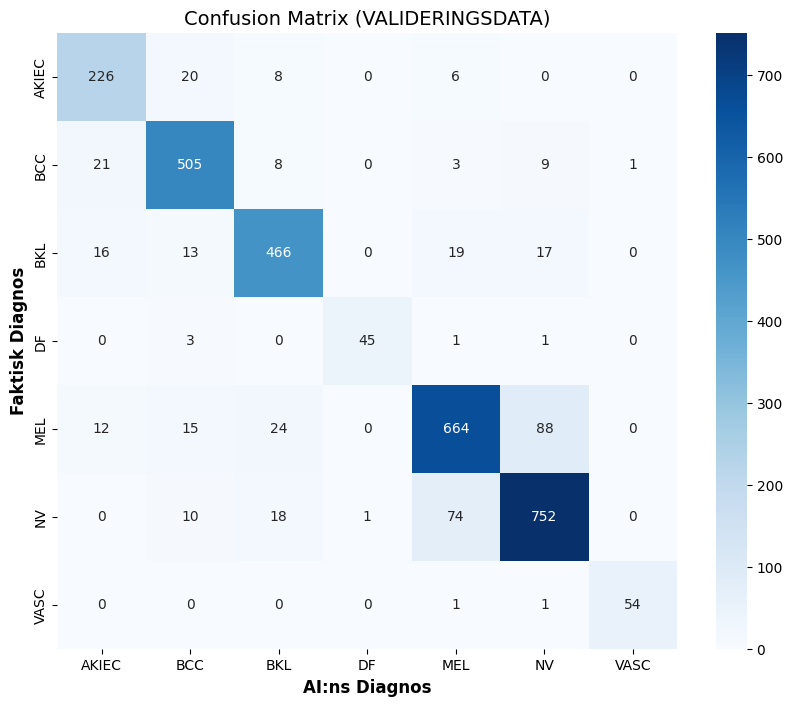

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_performance(model, dataset, title="VALIDERINGSDATA"):
    print(f" Genererar diagnoser för {title}...")
    
    y_true = []
    y_pred = []
    
    # 1. Hämta gissningar
    for batch_inp, batch_lbl in dataset:
        preds = model.predict(batch_inp, verbose=0)
        y_true.extend(batch_lbl.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        
    class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
    
    # 2. Skapa rapporten
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    
    # Korregering av matematik
    cols_to_pct = ['precision', 'recall', 'f1-score']
    df_report[cols_to_pct] = df_report[cols_to_pct] * 100
    
    # Antal bilder (support) ska förbli heltal
    df_report['support'] = df_report['support'].astype(int)
    
    # Döpa om kolumner för tydlighet
    df_report.rename(columns={
        'precision': 'Precision (%)', 
        'recall': 'Recall (%)', 
        'f1-score': 'F1-Score (%)', 
        'support': 'Antal Bilder (st)'
    }, inplace=True)
    
    # 3. Visa tabellen
    print("\n" + "="*65)
    print(f"KLINISK RAPPORT: {title}")
    print("="*65)
    
    display(df_report.head(7).style.format("{:.2f}", subset=['Precision (%)', 'Recall (%)', 'F1-Score (%)']) \
                             .background_gradient(cmap='RdYlGn', subset=['Recall (%)']))
    
    print(f"\nTotal Accuracy för hela setet: {accuracy_score(y_true, y_pred)*100:.2f}%")
    
    # 4. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('AI:ns Diagnos', fontsize=12, fontweight='bold')
    plt.ylabel('Faktisk Diagnos', fontsize=12, fontweight='bold')
    plt.title(f'Confusion Matrix ({title})', fontsize=14)
    plt.show()

# Utvärdering
evaluate_performance(model, val_ds, title="VALIDERINGSDATA")

___
# Block 6: Test på testdata & XAI-Visualisering

Testar Triple Ensemble på 5 bilder från testdata


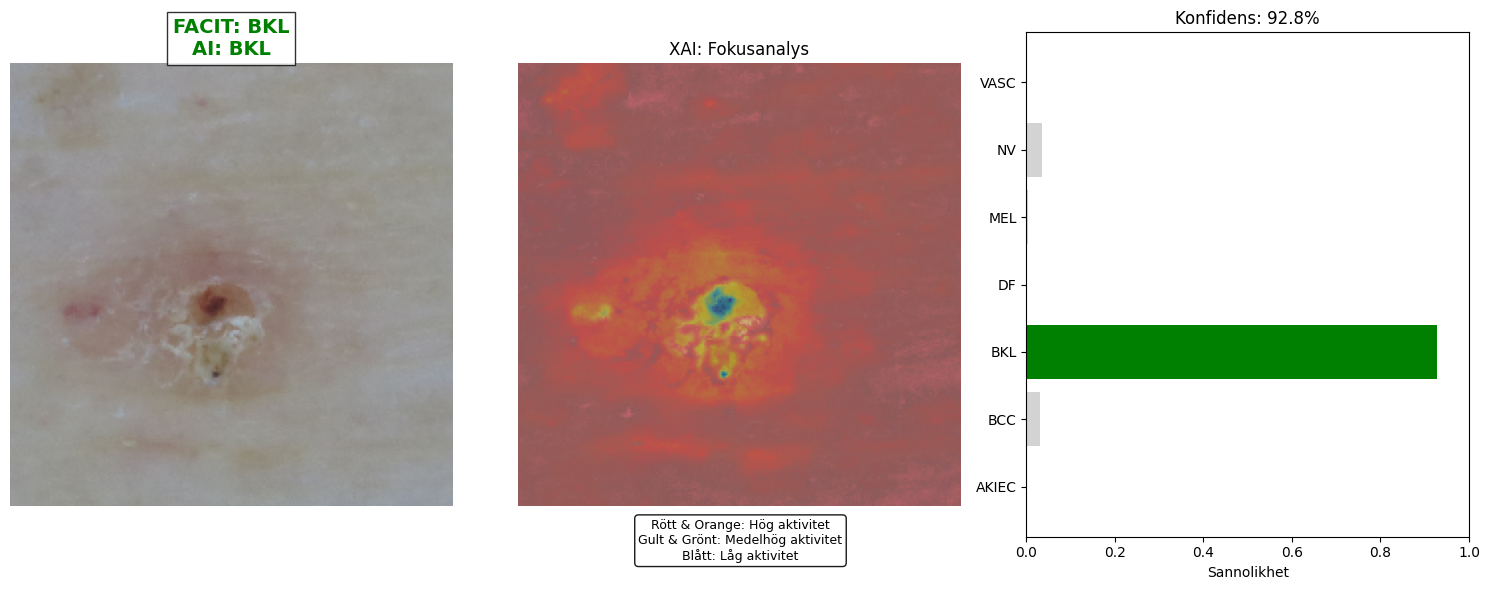

INFO: 53.40999081831745 år | Unknown | Område: Anterior torso
DIAGNOS: Modellen gissade BKL (92.8%)
----------------------------------------------------------------------------------------------------


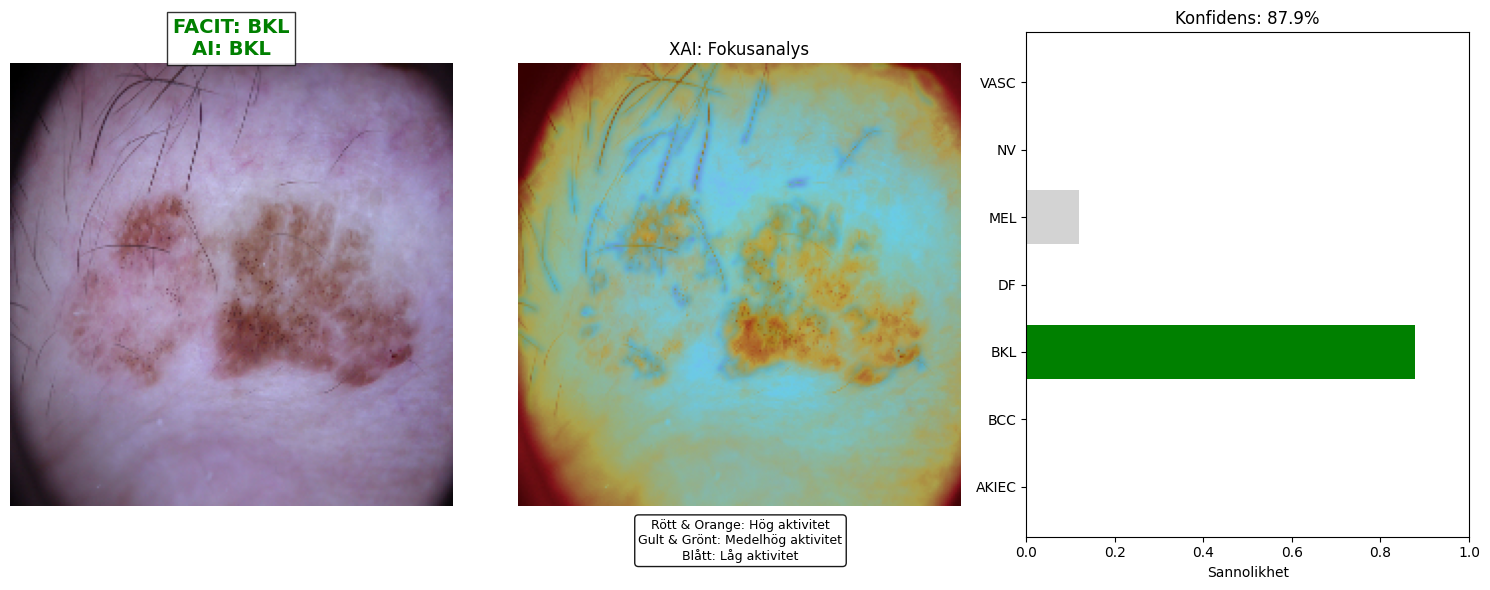

INFO: 75.0 år | Male | Område: Head/neck
DIAGNOS: Modellen gissade BKL (87.9%)
----------------------------------------------------------------------------------------------------


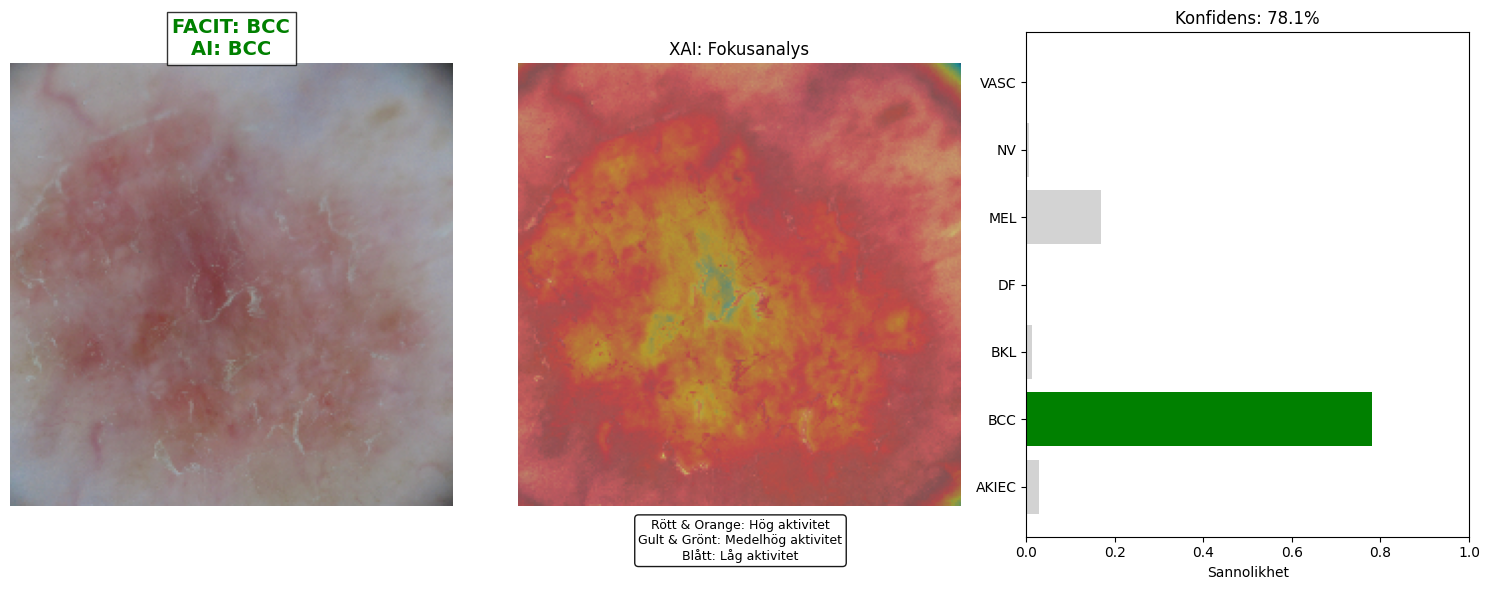

INFO: 75.0 år | Male | Område: Lower extremity
DIAGNOS: Modellen gissade BCC (78.1%)
----------------------------------------------------------------------------------------------------


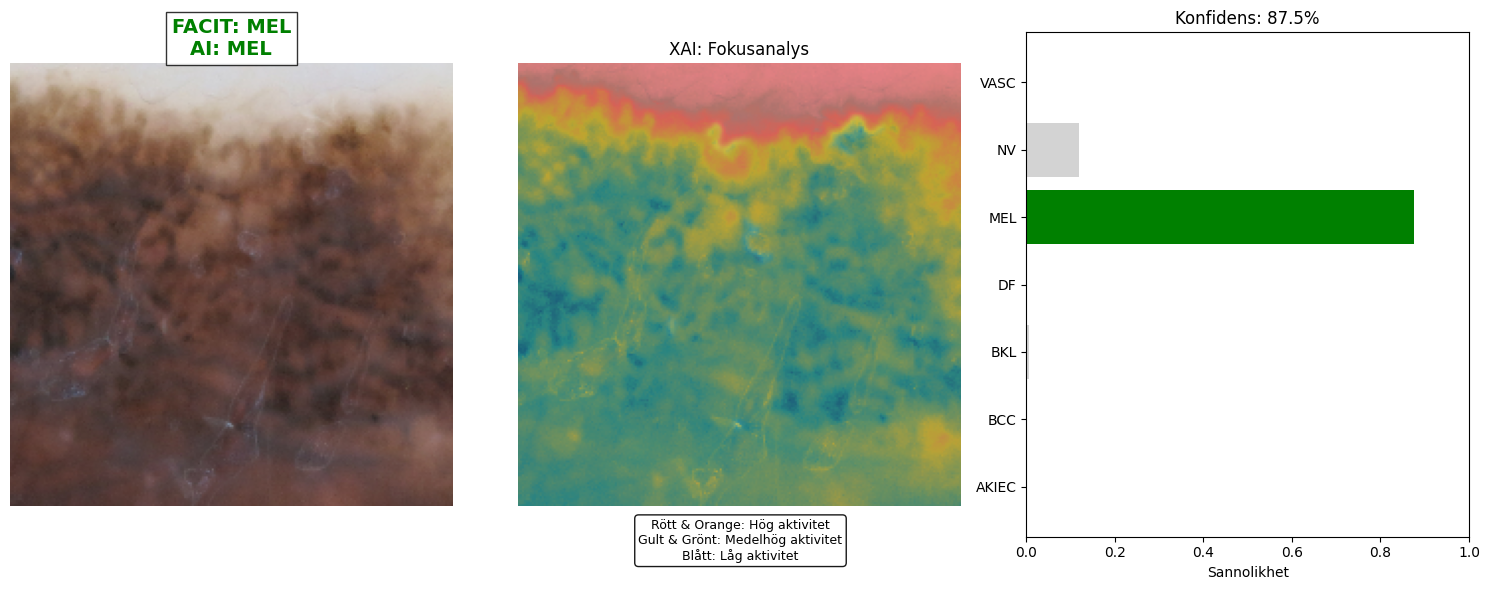

INFO: 70.0 år | Male | Område: Anterior torso
DIAGNOS: Modellen gissade MEL (87.5%)
----------------------------------------------------------------------------------------------------


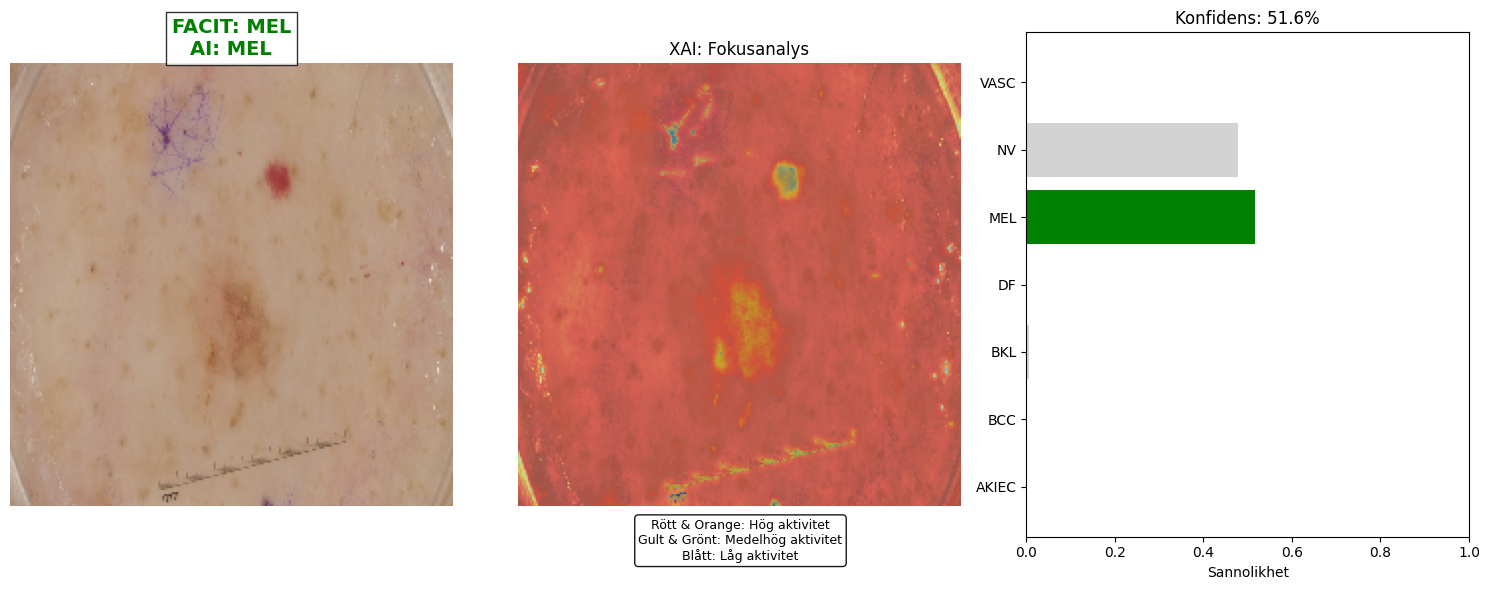

INFO: 70.0 år | Male | Område: Posterior torso
DIAGNOS: Modellen gissade MEL (51.6%)
----------------------------------------------------------------------------------------------------


In [23]:
# 1. XAI 
def generate_attention_map(img_rgb):

# Simulerar var en CNN letar efter ledtrådar: kanter, asymmetri och färgvariation.

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    # Kant-detektering (CNN:er reagerar starkt på strukturer)
    edges = cv2.Canny(gray, 50, 150)
    edges = cv2.GaussianBlur(edges, (7, 7), 0)
    
    # Kontrast-detektering (skillnad mellan fläck och hud)
    avg_skin = np.mean(img_rgb[:15, :15], axis=(0,1)) 
    diff = np.linalg.norm(img_rgb - avg_skin, axis=2)
    diff = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Kombinera och skapa heatmap
    combined = cv2.addWeighted(diff, 0.7, edges, 0.3, 0)
    heatmap = cv2.applyColorMap(combined, cv2.COLORMAP_JET)
    return heatmap

# 2. Huvudfunktion för visualisering
def visualize_final_test(model, df, count=5):
    print(f"Testar Triple Ensemble på {count} bilder från testdata")
    print("="*80)
    
    class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
    sample_df = df.sample(n=count)

    for idx, row in sample_df.iterrows():
        # A. Bild-Preprocessing
        path = row['path']
        img = cv2.imread(path)
        if img is None: continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_vis = cv2.resize(img_rgb, (224, 224))
        
        # Förbered för prediktion
        img_input = process_img(tf.convert_to_tensor(path), is_training=False)
        img_input = tf.expand_dims(img_input, axis=0)
        
        # B. Metadata-Preprocessing
        meta_input = row[meta_cols].values.astype(np.float32).reshape(1, -1)
        
        # C. Prediktion
        preds = model.predict({"image_input": img_input, "meta_input": meta_input}, verbose=0)[0]
        pred_idx = np.argmax(preds)
        true_idx = int(row['label'])
        
        confidence = preds[pred_idx]
        is_correct = (pred_idx == true_idx)
        
        # D. Hämtning av Patientinfo
        age = row.get('age_approx', '??')
        
        # Hitta kön
        gender = "Okänt"
        for c in row.index:
            if 'sex_' in c and row[c] == 1:
                gender = c.split('_')[-1].capitalize()
                break
        
        # Hitta plats
        loc = "Okänd"
        for c in row.index:
            if 'localization_' in c and row[c] == 1:
                loc = c.split('_')[-1].capitalize()
                break

        # E. Visualisering
        plt.figure(figsize=(15, 6)) 
        
        # Subplot 1: Originalbild
        plt.subplot(1, 3, 1)
        plt.imshow(img_vis)
        plt.axis('off')
        color = 'green' if is_correct else 'red'
        plt.title(f"FACIT: {class_names[true_idx]}\nAI: {class_names[pred_idx]}", 
                  color=color, fontsize=14, fontweight='bold', bbox=dict(facecolor='white', alpha=0.8))

        # Subplot 2: XAI Heatmap
        plt.subplot(1, 3, 2)
        heatmap = generate_attention_map(img_vis)
        superimposed = cv2.addWeighted(img_vis, 0.6, heatmap, 0.4, 0)
        plt.imshow(superimposed)
        plt.axis('off')
        plt.title("XAI: Fokusanalys", fontsize=12)
        
        # Lägg till förklarande text om fukusområden
        xai_info = "Rött & Orange: Hög aktivitet\nGult & Grönt: Medelhög aktivitet\nBlått: Låg aktivitet"
        plt.text(112, 230, xai_info, fontsize=9, ha='center', va='top', 
                 bbox=dict(boxstyle="round", facecolor='white', alpha=0.9))

        # Subplot 3: Sannolikhetsdiagram
        plt.subplot(1, 3, 3)
        colors = ['lightgray'] * 7
        colors[true_idx] = 'green'
        if not is_correct: colors[pred_idx] = 'red'
        
        y_pos = np.arange(len(class_names))
        plt.barh(y_pos, preds, color=colors)
        plt.yticks(y_pos, class_names)
        plt.xlabel('Sannolikhet')
        plt.title(f"Konfidens: {confidence*100:.1f}%")
        plt.xlim(0, 1)

        plt.tight_layout()
        plt.show()
        
        print(f"INFO: {age} år | {gender} | Område: {loc}")
        print(f"DIAGNOS: Modellen gissade {class_names[pred_idx]} ({confidence*100:.1f}%)")
        print("-" * 100)

# Kör testet
visualize_final_test(model, test_df, count=5)